Final Project Submission

>* Student name: Tamjid Ahsan
>* Student pace: full time
>* Scheduled project review date/time: 
>* Instructor name: James Irving
>* Blog post URL:

# Business Problem

Microsoft sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. I am going to try to figure out what types of films are currently doing the best at the box office. I shall remommend some actionable insights based on findings so that the head of Microsoft's new movie studio can use to help decide what type of films to create.

# The Data

Data is collected from IMDB website https://datasets.imdbws.com from downloadables and scraping. Additional data collected from TMDb using API.

## From TMDb API

In [ ]:
import json
import requests
import pandas as pd
import time
from pandas.core.common import flatten

In [ ]:
def get_keys(path):
    with open(path) as f:
        return json.load(f)

In [ ]:
keys = get_keys("/Users/tamji/.secret/tmdb_api.json")
api_key = keys['api_key']

In [ ]:
import tmdbsimple as tmdb
tmdb.API_KEY = api_key

In [ ]:
movie_titles_df=pd.read_csv(r'~/OneDrive/DS/project/ta/movie_main_df_sliced.csv', usecols=["tconst"])

In [ ]:
imdb_titles = list(flatten(movie_titles_df.values.tolist()))

In [ ]:
len(imdb_titles)

In [ ]:
df = pd.DataFrame()

In [ ]:
for imdb_id in imdb_titles:    
    try:
        movie = tmdb.Movies(imdb_id)
        response = movie.info()
        df = df.append(pd.json_normalize(movie.info()))
    except:
        pass

In [ ]:
df = df.reset_index()

In [ ]:
df = df.drop(columns=['index'])

In [ ]:
df.to_csv(r'~/OneDrive/DS/project/ta/df1.csv')

## from IMDb

### Scraping

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
import os
import wget
import pandas as pd

In [ ]:
driver = webdriver.Chrome('C:/Users/tamji/Documents/PATH/chromedriver.exe')

In [ ]:
base_url_string = 'https://www.boxofficemojo.com/year/world/'
list_of_year = np.arange(2007, 2021, 1)

In [ ]:
%%time
print(f'+' * 100)
file_names_ = []
file_names_error = []
for im in list_of_year:
    print(f'Working on {im}')
    url = f'{base_url_string}{im}/'
    print(f'Getting {im} homepage')
    driver.get(url)
    table = driver.find_element_by_xpath('//*[@id="table"]/div/table[2]')
    item_href = driver.find_elements_by_class_name('a-link-normal')
    print(f'Getting {im} list items')
    item_href = [item.get_property('href') for item in item_href]
    print(f'Sorting what to keep from {im} list items')
    text_to_check = 'releasegroup'
    to_keep = []
    to_discard = []
    for i in item_href:
        if text_to_check in i:
            to_keep.append(i)
        else:
            to_discard.append(i)
    print(f'Preping {im} list items for looping')
    href = to_keep[:3]
    master_list = []
    error = []
    print(f'{im} list items are looping. Hang in there!')
    for item in href:
        try:
            driver.get(item)
            url = driver.find_element_by_xpath(
                '//*[@id="title-summary-refiner"]/a').get_property('href')
            name = driver.find_element_by_xpath(
                '//*[@id="a-page"]/main/div/div[1]/div[1]/div/div/div[2]/h1'
            ).text

            driver.get(url)
            year = driver.find_element_by_xpath(
                '//*[@id="a-page"]/main/div/div[1]/div[1]/div/div/div[2]/div/h1/span'
            ).text
            worldwide = driver.find_element_by_xpath(
                '//*[@id="a-page"]/main/div/div[3]/div[1]/div/div[3]/span[2]/span'
            ).text
            international = driver.find_element_by_xpath(
                '//*[@id="a-page"]/main/div/div[3]/div[1]/div/div[2]/span[2]'
            ).text
            domestic = driver.find_element_by_xpath(
                '//*[@id="a-page"]/main/div/div[3]/div[1]/div/div[1]/span[2]'
            ).text

            year_cleaned = year.strip('()')
            world_collection = worldwide[1:].replace(",", "")
            international_collection = international[1:].replace(",", "")
            domestic_collection = domestic[1:].replace(",", "")
            imdb_code = url.split('/')[4]

            temp_dict = {
                'imdb_code': imdb_code,
                'name': name,
                'year': year_cleaned,
                'world_collection': world_collection,
                'int_collection': international_collection,
                'dom_collection': domestic_collection,
                'url': url
            }
            master_list.append(temp_dict)
        except:
            error.append(item)
            continue

    df = pd.DataFrame(master_list)
    file_name_df = f'{im}.csv'
    df.to_csv(file_name_df, index=False)
    dict_ = {'urls': error}
    file_name_error = f'{im}_error.csv'
    pd.DataFrame(dict_).to_csv(file_name_error, index=False)
    file_names_.append(file_name_df)
    file_names_error.append(file_name_error)
    print(f'Finished working on {im}\n')
    print(f'+' * 100)
print(f'\n\n\nDONE Looping. Cleanig data!!!')

combined_csv_data = pd.concat([pd.read_csv(f) for f in file_names_])
combined_csv_data_error = pd.concat([pd.read_csv(f) for f in file_names_error])

combined_csv_data.reset_index(inplace=True)
combined_csv_data_error.reset_index(inplace=True)

combined_csv_data=combined_csv_data.drop(columns='index')
combined_csv_data_error=combined_csv_data_error.drop(columns='index')

combined_csv_data = combined_csv_data.drop_duplicates('imdb_code', ignore_index=True)

file_name_1 = f'{list_of_year[0]}to{list_of_year[-1]}.csv'
file_name_2 = f'{list_of_year[0]}to{list_of_year[-1]}_error.csv'
combined_csv_data.to_csv(file_name_1, index=False)
combined_csv_data_error.to_csv(file_name_2, index=False)

print(f'\n\n\nDONE!!!')
print(f'+' * 100)
print(f'+' * 100)

### dataset from website

file containing detailed movie info inside title.basics.tsv.gz was downloaded from https://datasets.imdbws.com/title.basics.tsv.gz

# Cleaning

## IMDb

In [ ]:
%%time
df_1 = pd.read_csv(r'~\OneDrive\DS\project\ta\data.tsv',
                   delimiter='\t',
                   low_memory=False)

In [ ]:
df_1['titleType'].value_counts()

In [ ]:
%%time
movie_df = df_1[df_1['titleType'] == 'movie']

movie_df = movie_df[movie_df['isAdult'] == '0']
movie_df.loc[movie_df['runtimeMinutes'] == r'\N', 'runtimeMinutes'] = np.nan
movie_df.loc[movie_df['startYear'] == r'\N', 'startYear'] = np.nan
movie_df.loc[movie_df['genres'] == r'\N', 'genres'] = np.nan
movie_df.loc[movie_df['genres'].isna(), 'genres'] = "NoInfo"
movie_df = movie_df[~movie_df['startYear'].isna()]

movie_df = movie_df.reset_index()
movie_df = movie_df.drop(['index', 'titleType', 'endYear', 'isAdult'], axis=1)

movie_df.to_csv(r'~\OneDrive\DS\project\ta\movie_df.csv', index=False)
movie_df

In [ ]:
%%time
# getting preliminary unique list for cleaning
genres = list(movie_df['genres'].unique())
# temp list to store list of splited genre
genre_cleaning_temp = []
# getting list of splited genre
for item in genres:
    # for dealing with nan
    if type(item) is not float:
        # actual spliting
        genre_split = item.split(",")
        # appending
        genre_cleaning_temp.extend(genre_split)
# geting unique list
from pandas.core.common import flatten
# flattening temp list
## https://stackoverflow.com/questions/12897374/get-unique-values-from-a-list-in-python by https://stackoverflow.com/users/2062318/todor ##
## https://saralgyaan.com/posts/nested-list-to-list-python-in-just-three-lines-of-code/ ##
genre_cleaning_temp = list(flatten(genre_cleaning_temp))
# unique genre list
unique_genre = list(dict.fromkeys(genre_cleaning_temp))
unique_genre

In [ ]:
%%time
movie_genre_df = pd.DataFrame([[(x in y) for x in unique_genre]
                               for y in movie_df['genres']],
                              columns=unique_genre)

In [ ]:
movie_main_df = pd.concat([movie_df, movie_genre_df], axis=1)

In [ ]:
movie_main_df = movie_main_df.convert_dtypes()

In [ ]:
movie_main_df['startYear'] = movie_main_df['startYear'].astype('int')
movie_main_df['runtimeMinutes'].fillna('0', inplace=True)
movie_main_df['runtimeMinutes'] = movie_main_df['runtimeMinutes'].astype('int')

In [ ]:
movie_main_df['startYear'].sort_values().unique()

In [ ]:
movie_main_df_sliced = movie_main_df[(movie_main_df['startYear'] >= 2007)
                                     & (movie_main_df['startYear'] <= 2021)]

In [ ]:
movie_main_df_sliced.describe()

In [ ]:
to_drop = [
    'Documentary', 'Short', 'Adult', 'Reality-TV', 'Game-Show', 'Talk-Show',
    'News', 'Film-Noir'
]

In [ ]:
for item in to_drop:
    movie_main_df_sliced=movie_main_df_sliced[~movie_main_df_sliced[item].eq(1)]

In [ ]:
movie_main_df_sliced

In [ ]:
for item in to_drop:
    movie_main_df_sliced=movie_main_df_sliced.drop(columns=item,axis=1)

In [ ]:
movie_main_df_sliced.to_csv('movie_main_df_sliced.csv',index = False)

## merging with others sources

In [ ]:
imdb_df = pd.read_csv('movie_main_df_sliced.csv')
bom_df = pd.read_csv('imdb_07to21_cleaned.csv')
tmdb_df = pd.read_csv('tmdb_parsd.csv')
tmdb_df = tmdb_df.drop(tmdb_df.columns[0:4], axis=1)

In [ ]:
merge_1 = pd.merge(imdb_df,
                   bom_df,
                   how='left',
                   left_on='tconst',
                   right_on='imdb_code')

In [ ]:
tmdb_df.columns

In [ ]:
filter_list = [
    'imdb_id', 'title', 'budget', 'revenue', 'release_date',
    'production_companies', 'popularity', 'vote_average', 'vote_count',
    'overview', 'belongs_to_collection.name'
]

In [ ]:
tmdb_df_reduced = tmdb_df[filter_list]

In [ ]:
merge_2 = pd.merge(merge_1,
                   tmdb_df_reduced,
                   how='inner',
                   left_on='tconst',
                   right_on='imdb_id')

In [ ]:
df = merge_2.copy()
pd.set_option('display.max_columns', len(df.columns))

In [ ]:
# cleaning

In [ ]:
rearrange = [
    'tconst', 'imdb_code', 'imdb_id', 'primaryTitle', 'originalTitle', 'name',
    'title', 'startYear', 'year', 'release_date', 'runtimeMinutes', 'budget',
    'revenue', 'world_collection', 'int_collection', 'dom_collection',
    'production_companies', 'popularity', 'vote_average', 'vote_count',
    'overview', 'belongs_to_collection.name', 'genres', 'NoInfo', 'Action',
    'Adventure', 'Biography', 'Drama', 'Fantasy', 'Comedy', 'War', 'Crime',
    'Romance', 'Family', 'History', 'Sci-Fi', 'Thriller', 'Western', 'Sport',
    'Mystery', 'Horror', 'Music', 'Animation', 'Musical', 'url'
]
df = df[rearrange]

filtering order: 
1. financial data
2. year
3.  review data


In [ ]:
df['revenue'].sort_values().value_counts()

In [ ]:
df['world_collection'].isna().value_counts()

In [ ]:
((df['revenue']!=0)&(df['world_collection'].isna())).value_counts()

In [ ]:
condition_1 = (df['revenue']!=0)

In [ ]:
condition_2 = ~df['world_collection'].isna()

In [ ]:
df = df[condition_1 | condition_2]

In [ ]:
df

In [ ]:
df.loc[:,['world_collection']] = df[['revenue','world_collection']].max(axis=1)

In [ ]:
drop_list = [
    'tconst', 'imdb_id', 'index','name', 'title', 'year', 'revenue', 'url'
]

In [ ]:
df = df.reset_index()

In [ ]:
df = df.drop(columns=drop_list)

In [ ]:
df["release_date"] = pd.to_datetime(df["release_date"]) 

In [ ]:
# dealing with nested data

In [ ]:
df1 = df.copy()

In [ ]:
df1 = df1[['imdb_code','production_companies']]

In [ ]:
df1_dict=df1.to_dict()

In [ ]:
df1_dict.keys()

In [ ]:
# https://stackoverflow.com/questions/39807724/extract-python-dictionary-from-string by https://stackoverflow.com/users/3734244/danidee
import re
import ast

In [ ]:
def get_list(string):
    x = ast.literal_eval(re.search('({.+})', string).group(0))
    return x

In [ ]:
temp = []
ty = []
for item in df1_dict['production_companies']:
    x = df1_dict['production_companies'][item]
    try:
        temp.append(get_list(x))
    except:
        temp.append(ty)

In [ ]:
temp

In [ ]:
temp_li = []

for i in temp:
    if type(i) == tuple:
        lli = []
        for y in i:
            lli.append(y['name'])
        code = ', '.join(lli)
        temp_dict = {
            'production_comp': code,
        }   
        temp_li.append(temp_dict)
    elif type(i) == dict:
#         print(i['name'])
        code = i['name']
        temp_dict = {
            'production_comp': code,
        }   
        temp_li.append(temp_dict)

    elif type(i) == list:
#         print('empty')
        code = 'empty'
        temp_dict = {
                    'production_comp': code,
                }    
        temp_li.append(temp_dict)

temp_li

In [ ]:
pro = pd.DataFrame.from_dict(temp_li)

In [ ]:
pro_1=pd.concat([df1.reset_index(),pro],axis=1)

In [ ]:
pro_1=pro_1.drop(axis=1, columns=['index','production_companies'])

In [ ]:
df_final = pd.merge(df, pro_1, left_on='imdb_id', right_on='imdb_id')

In [ ]:
# touchup

In [ ]:
df_final.head(4)

In [ ]:
df_final.columns

In [ ]:
df_final=df_final.drop(columns='production_companies')

In [ ]:
rearrange = [
    'imdb_id',
    'primaryTitle',
    'originalTitle',
    'startYear',
    'release_date',
    'runtimeMinutes',
    'budget',
    'world_collection',
    'int_collection',
    'dom_collection',
    'production_comp',
    'popularity',
    'vote_average',
    'vote_count',
    'overview',
    'belongs_to_collection.name',
    'genres',
    'NoInfo',
    'Action',
    'Adventure',
    'Biography',
    'Drama',
    'Fantasy',
    'Comedy',
    'War',
    'Crime',
    'Romance',
    'Family',
    'History',
    'Sci-Fi',
    'Thriller',
    'Western',
    'Sport',
    'Mystery',
    'Horror',
    'Music',
    'Animation',
    'Musical',
]
df_final[rearrange]

In [ ]:
df_final.to_csv('df_final.csv', index=False)

# names df

In [54]:
%%time
df = pd.read_csv(r'~\OneDrive\DS\project\ta\names_basic.tsv',
                   delimiter='\t',
                   low_memory=False)

Wall time: 20.2 s


In [55]:
df.describe()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
count,10775161,10775161,10775161,10775161,8505080,10775161
unique,10775161,8401393,503,442,20224,4466655
top,nm3628788,David Smith,\N,\N,actor,\N
freq,1,336,10254805,10588397,1935754,1975674


In [56]:
df = df.dropna()

## find director

In [57]:
df.loc[:,'profession'] = df['primaryProfession'].map(lambda x: x.split(','))

In [58]:
df = df.explode('profession')

In [59]:
director_df = df[df['profession'] == 'director']

In [29]:
director_df

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,profession
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050976,tt0050986,tt0060827,tt0069467",director
7,nm0000008,Marlon Brando,1924,2004,"actor,soundtrack,director","tt0047296,tt0068646,tt0070849,tt0078788",director
9,nm0000010,James Cagney,1899,1986,"actor,soundtrack,director","tt0035575,tt0042041,tt0029870,tt0031867",director
18,nm0000019,Federico Fellini,1920,1993,"writer,director,assistant_director","tt0056801,tt0071129,tt0047528,tt0050783",director
23,nm0000024,John Gielgud,1904,2000,"actor,writer,director","tt0071877,tt0082031,tt0117631,tt0045943",director
...,...,...,...,...,...,...,...
10775088,nm9993645,Fotis Georgopoulos,\N,\N,director,\N,director
10775122,nm9993679,Art Jones,\N,\N,director,tt8744074,director
10775138,nm9993696,Ibrahim-Aloduley,\N,\N,"director,editor",\N,director
10775150,nm9993708,Eli Bevins,\N,\N,"director,writer,editor","tt11753904,tt11772858,tt11702702,tt11772904",director


## finding actor/actress

In [30]:
actors = df[(df['profession'] == 'actor') | (df['profession'] == 'actress')]

In [31]:
actors

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,profession
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0050419,tt0053137,tt0072308,tt0031983",actor
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0037382,tt0117057,tt0075213,tt0038355",actress
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0054452,tt0057345,tt0049189,tt0056404",actress
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0080455,tt0072562,tt0077975,tt0078723",actor
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050976,tt0050986,tt0060827,tt0069467",actor
...,...,...,...,...,...,...,...
10775140,nm9993698,Sebi John,\N,\N,actor,tt8736744,actor
10775141,nm9993699,Dani Jacob,\N,\N,actor,tt8736744,actor
10775142,nm9993700,Sexy Angel,\N,\N,actress,\N,actress
10775143,nm9993701,Sanjai Kuriakose,\N,\N,actor,tt8736744,actor


In [24]:
# df.groupby('profession').count().sort_values('nconst',ascending=False)

# main_df

In [1]:
main_df_raw = pd.read_csv(r'df_final.csv',parse_dates=['release_date'])

In [2]:
main_df=main_df_raw.iloc[:,0:17]

In [3]:
main_df['release_year'] = main_df['release_date'].dt.year

In [4]:
main_df=main_df[~main_df.release_date.isna()]

In [5]:
main_df = main_df[(main_df.release_date >= '2020-01-01')
                  & (main_df.release_date <= '2020-12-31')]

In [6]:
# main_df.sort_values('world_collection')

In [7]:
main_df = main_df[main_df.budget>=5000] #change this main_df.budget.mean()

In [8]:
main_df['ROI'] = main_df.world_collection - main_df.budget

In [9]:
main_df['ROI_percentage'] = main_df.ROI / main_df.budget

In [10]:
main_df.describe()

,startYear,runtimeMinutes,budget,world_collection,int_collection,dom_collection,popularity,vote_average,vote_count,release_year,ROI,ROI_percentage
count,118.000000,118.000000,1.180000e+02,1.180000e+02,9.800000e+01,5.000000e+01,118.000000,118.000000,118.000000,118.0,1.180000e+02,118.000000
mean,2019.898305,104.110169,2.335608e+07,3.358090e+07,2.700243e+07,2.313233e+07,102.943051,5.905932,729.118644,2020.0,1.022483e+07,2.871941
std,0.378703,24.880152,4.436783e+07,8.034445e+07,6.626190e+07,3.959792e+07,288.339724,2.280024,1444.016106,0.0,6.021770e+07,17.345388
min,2018.000000,0.000000,5.000000e+03,1.900000e+01,1.900000e+01,5.208000e+03,0.600000,0.000000,0.000000,2020.0,-1.332000e+08,-0.999991
25%,2020.000000,92.000000,1.238750e+06,1.835608e+05,2.864732e+05,7.724418e+05,4.134750,5.600000,5.250000,2020.0,-4.777155e+06,-0.898841
50%,2020.000000,102.000000,5.900000e+06,2.872624e+06,2.629546e+06,7.421678e+06,13.755000,6.500000,69.000000,2020.0,-1.697055e+05,-0.295353
75%,2020.000000,116.000000,2.000000e+07,2.713923e+07,1.660585e+07,2.193259e+07,43.032000,7.300000,639.250000,2020.0,7.280119e+06,1.322932
max,2021.000000,169.000000,2.050000e+08,4.613415e+08,4.609688e+08,2.063052e+08,2103.518000,8.800000,7091.000000,2020.0,3.813415e+08,142.731880


In [11]:
# main_df[main_df.ROI>0]

## top movie by return %

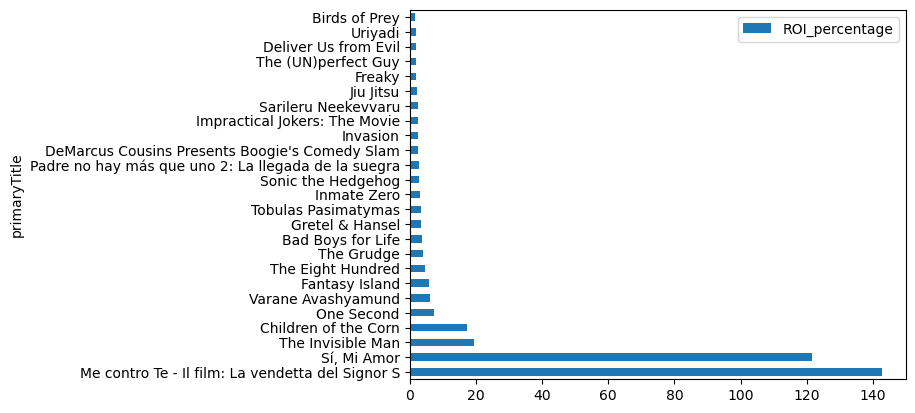

In [12]:
main_df.sort_values(by='ROI_percentage',
                    ascending=False).head(25).plot(kind='barh',
                                                   x='primaryTitle',
                                                   y='ROI_percentage')
plt.show()

## top movie by gross profit

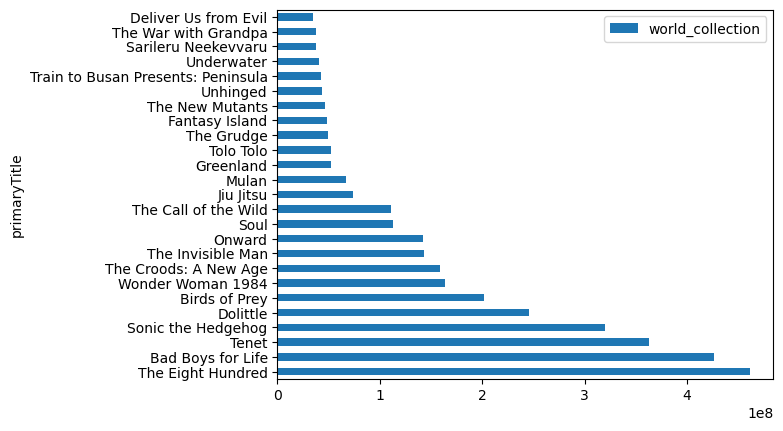

In [13]:
main_df.sort_values(by='world_collection',
                    ascending=False).head(25).plot(kind='barh',
                                                   x='primaryTitle',
                                                   y='world_collection')
plt.show()

## profit by top 20 studio

In [14]:
studio_df = main_df.copy()

In [15]:
studio_df.loc[:, 'production_comp_exp'] = studio_df.production_comp.map(
    lambda x: x.split(', '))

In [16]:
studio_df_fig = studio_df.explode('production_comp_exp')

In [17]:
studio_df_fig.head(3)

,imdb_id,primaryTitle,originalTitle,startYear,release_date,runtimeMinutes,budget,world_collection,int_collection,dom_collection,...,vote_average,vote_count,overview,belongs_to_collection.name,genres,production_comp,release_year,ROI,ROI_percentage,production_comp_exp
825,tt0783640,The Last Full Measure,The Last Full Measure,2019,2020-01-23,116,20000000,3364426,415214.0,2949212.0,...,7.7,247,The incredible true story of Vietnam War hero ...,NaN,"Drama,War","Foresight Unlimited, Provocator, SSS Entertain...",2020.0,-16635574,-0.831779,Foresight Unlimited
825,tt0783640,The Last Full Measure,The Last Full Measure,2019,2020-01-23,116,20000000,3364426,415214.0,2949212.0,...,7.7,247,The incredible true story of Vietnam War hero ...,NaN,"Drama,War","Foresight Unlimited, Provocator, SSS Entertain...",2020.0,-16635574,-0.831779,Provocator
825,tt0783640,The Last Full Measure,The Last Full Measure,2019,2020-01-23,116,20000000,3364426,415214.0,2949212.0,...,7.7,247,The incredible true story of Vietnam War hero ...,NaN,"Drama,War","Foresight Unlimited, Provocator, SSS Entertain...",2020.0,-16635574,-0.831779,SSS Entertainment


In [18]:
top_production_house_list = list(studio_df_fig.production_comp_exp.value_counts().sort_values(ascending=False)[1:20].index)#.reset_index() # to drop empty

In [19]:
studio_df_fig_0 = studio_df_fig[studio_df_fig.production_comp_exp.isin(top_production_house_list)]

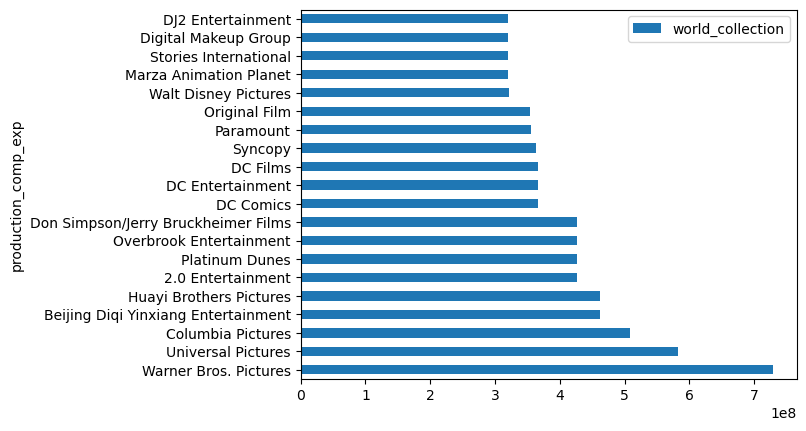

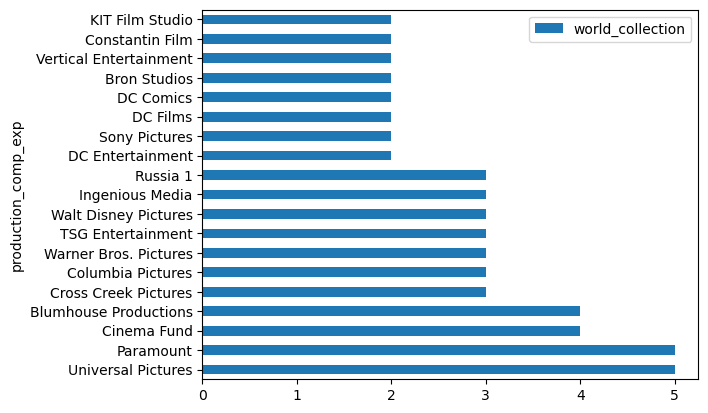

In [20]:
studio_df_fig_1 = studio_df_fig.groupby(
    by='production_comp_exp').agg('sum').sort_values(by='world_collection',
                                                     ascending=False)[:20]
studio_df_fig_2 = studio_df_fig.groupby(
    by='production_comp_exp').agg('count').sort_values(by='world_collection',
                                                       ascending=False)[1:20]

studio_df_fig_1.plot(kind='barh',
                     y='world_collection')
studio_df_fig_2.plot(kind='barh',
                     y='world_collection')
plt.show()

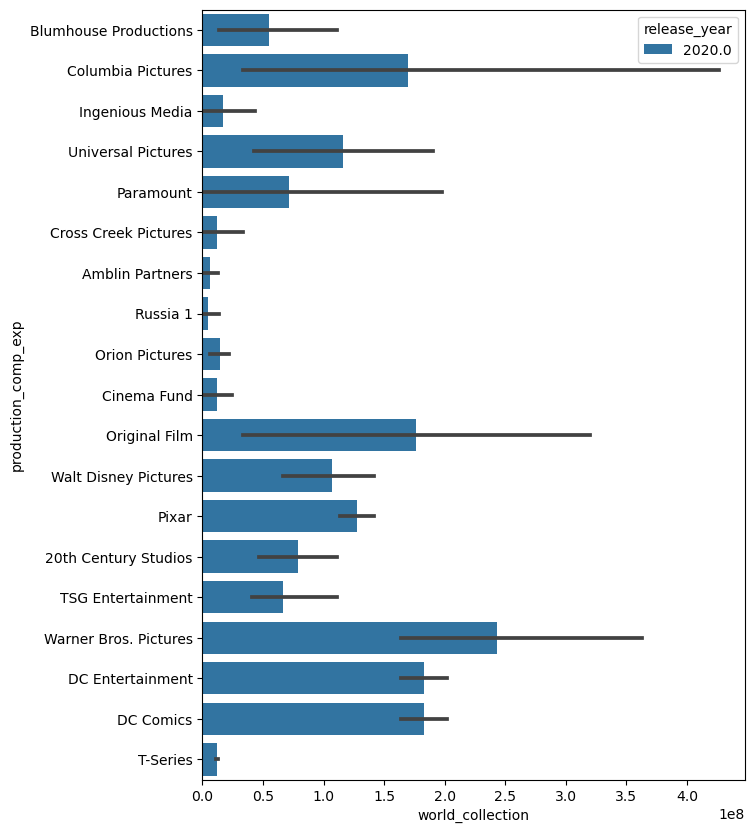

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 10)
sns.barplot(data=studio_df_fig_0,
            y='production_comp_exp',
            x='world_collection',
            hue='release_year')
plt.show()

## top movie by genere 

In [22]:
genere_df = main_df.copy()

In [23]:
genere_df.loc[:,'genres_exp'] = genere_df.genres.map(lambda x: x.split(','))

In [24]:
genere_df_fig = genere_df.explode('genres_exp')

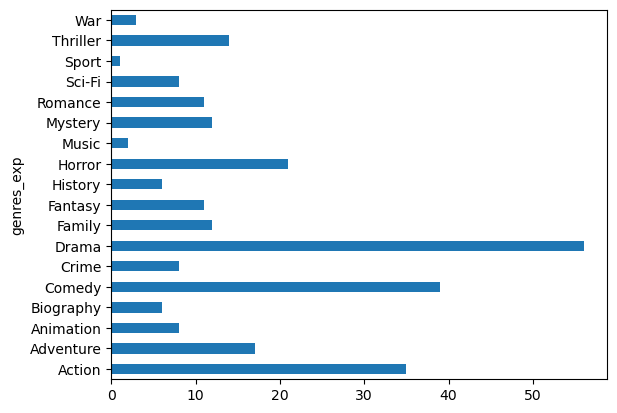

In [25]:
genere_df_fig.groupby('genres_exp').count()['imdb_id'].plot(kind='barh')
plt.show()

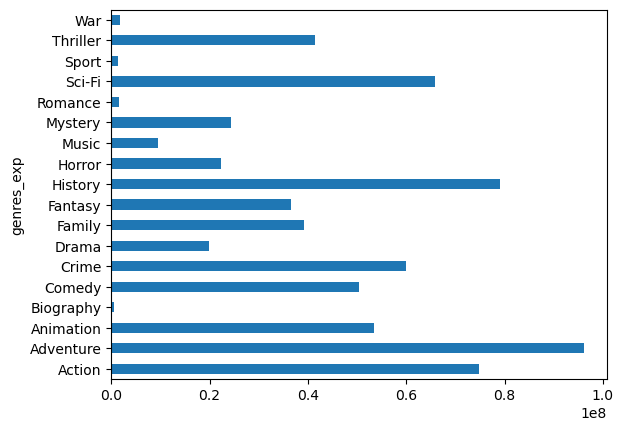

In [26]:
genere_df_fig.groupby('genres_exp').mean()['world_collection'].plot(
    kind='barh')
plt.show()

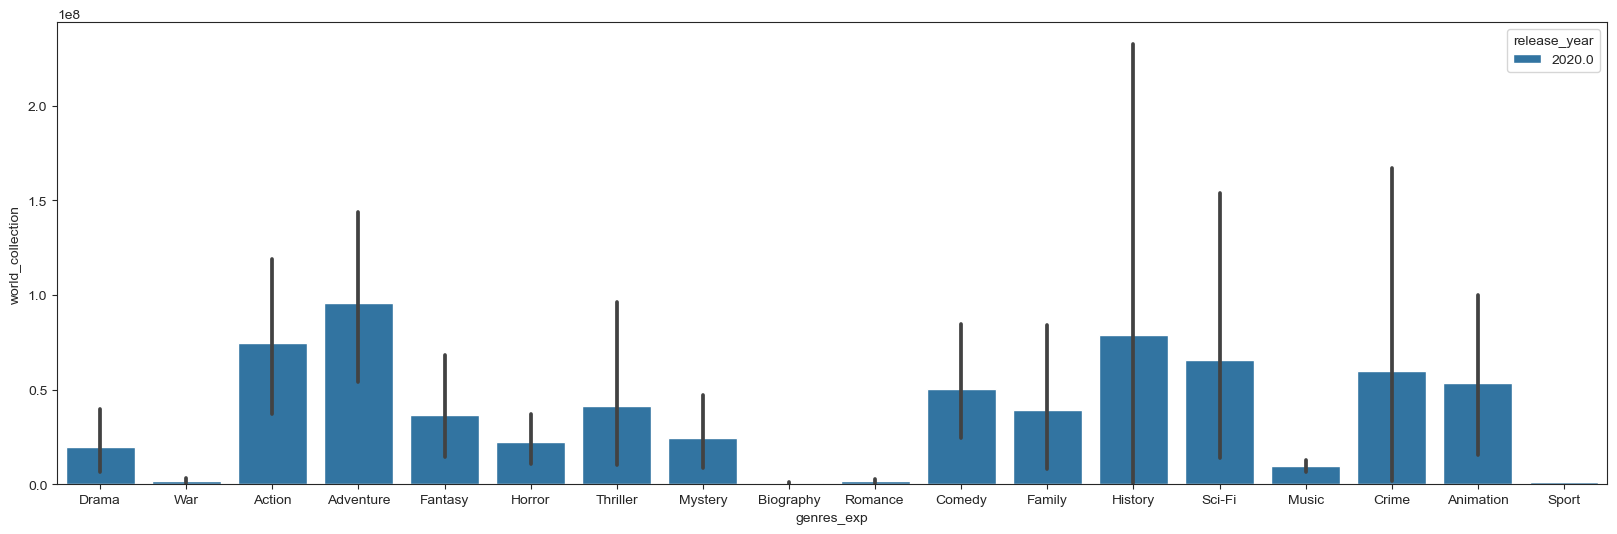

In [27]:
# styling
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
# plotting
sns.barplot(data=genere_df_fig,
            x='genres_exp',
            y='world_collection',
            hue='release_year')
plt.show()

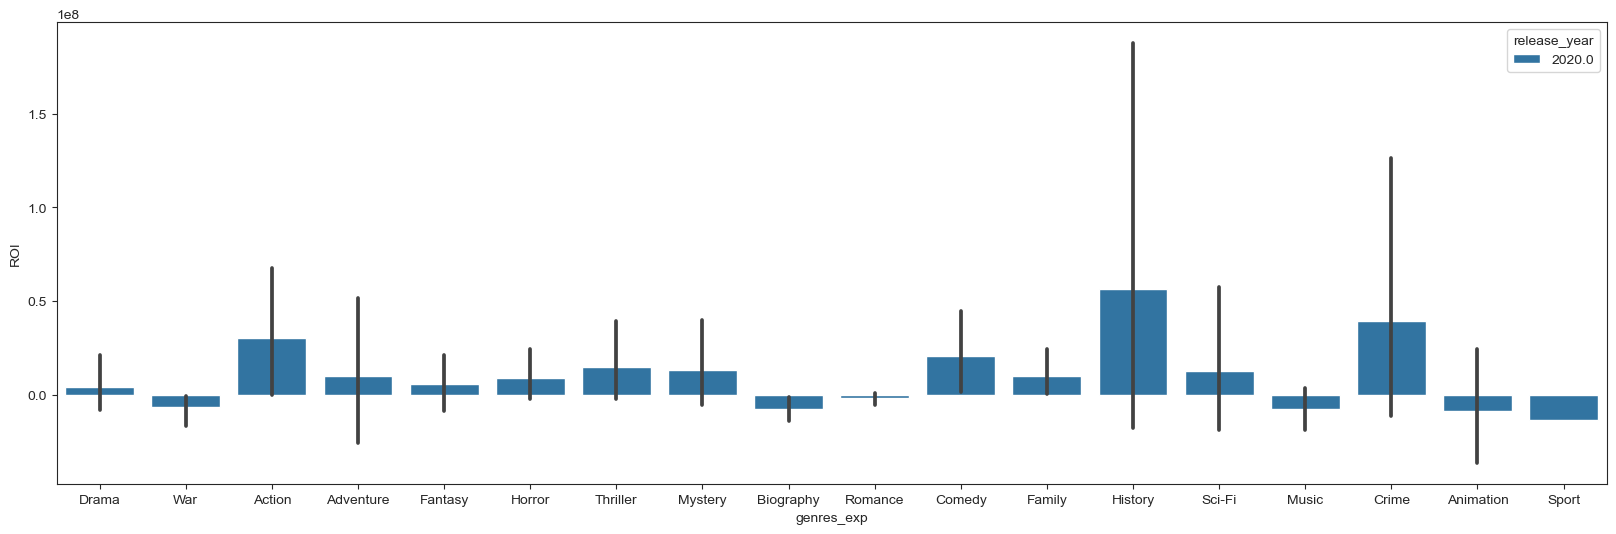

In [28]:
# styling
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
# plotting
sns.barplot(data=genere_df_fig,
            x='genres_exp',
            y='ROI',
            hue='release_year')
plt.show()

## best time to release mov

In [29]:
timing_df = main_df.copy()

In [30]:
timing_df['release_month']=timing_df['release_date'].dt.month

In [31]:
timing_df['release_timing'] = pd.cut(timing_df['release_month'],bins=[0,6,8,10,12],labels=['dump months', 'summer','dump months','holidays'],ordered=False)

In [32]:
timing_df.head(3)

,imdb_id,primaryTitle,originalTitle,startYear,release_date,runtimeMinutes,budget,world_collection,int_collection,dom_collection,...,vote_count,overview,belongs_to_collection.name,genres,production_comp,release_year,ROI,ROI_percentage,release_month,release_timing
825,tt0783640,The Last Full Measure,The Last Full Measure,2019,2020-01-23,116,20000000,3364426,415214.0,2949212.0,...,247,The incredible true story of Vietnam War hero ...,NaN,"Drama,War","Foresight Unlimited, Provocator, SSS Entertain...",2020.0,-16635574,-0.831779,1,dump months
2009,tt0983946,Fantasy Island,Fantasy Island,2020,2020-02-12,109,7000000,48811343,21502054.0,27309289.0,...,1450,A group of contest winners arrive at an island...,NaN,"Action,Adventure,Fantasy","Blumhouse Productions, Columbia Pictures",2020.0,41811343,5.973049,2,dump months
2230,tt10044182,Block Z,Block Z,2020,2020-01-29,101,646955,709452,NaN,NaN,...,6,A pre-med student and her friends encounter th...,NaN,"Action,Horror,Thriller","Star Cinema – ABS-CBN Film Productions, Keep F...",2020.0,62497,0.096602,1,dump months


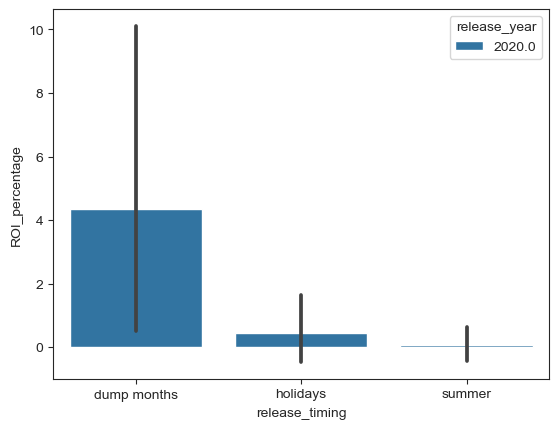

In [33]:
sns.barplot(data=timing_df, x='release_timing', y='ROI_percentage',hue='release_year')
plt.show()

## franchaise performance

In [34]:
franchaise_df_main = main_df.copy()

In [35]:
franchaise_df = main_df[~main_df['belongs_to_collection.name'].isna()]

In [36]:
franchaise_df = franchaise_df.rename(columns={"belongs_to_collection.name": "belongs_to_collection"})

In [37]:
non_franchaise_df = main_df[main_df['belongs_to_collection.name'].isna()].copy()

### franchaise info

In [38]:
list_of_franchaise = franchaise_df['belongs_to_collection'].unique()

In [39]:
franchaise_df_ = franchaise_df.groupby('belongs_to_collection').mean().ROI_percentage.sort_values(ascending=False).reset_index()

In [40]:
from pandasql import sqldf

In [41]:
list_of_franchaise_df = sqldf(
    """SELECT belongs_to_collection, a.ROI_percentage AS 'ROI%', b.genres FROM franchaise_df_ AS a JOIN franchaise_df AS b USING(belongs_to_collection);"""
)
list_of_franchaise_df[:15].style.background_gradient()

,belongs_to_collection,ROI%,genres
0,Me contro Te - Saga,142.731880,"Comedy,Family"
1,Children of the Corn Collection,17.211236,Horror
2,Bad Boys Collection,3.738947,"Action,Comedy,Crime"
3,Sonic The Hedgehog Collection,2.761361,"Action,Adventure,Comedy"
4,Padre no hay más que uno - Colección,2.717827,Comedy
5,Attraction Collection,2.640246,"Action,Sci-Fi"
6,Suicide Squad Collection,1.691446,"Action,Adventure,Comedy"
7,Train to Busan Collection,1.511666,"Action,Horror,Thriller"
8,The Croods Collection,1.441442,"Adventure,Animation,Comedy"
9,Baaghi Collection,1.103315,"Action,Thriller"


#### which genre for franchaise

In [42]:
list_of_franchaise_df.loc[:, 'genres_exp'] = list_of_franchaise_df.genres.map(
    lambda x: x.split(','))
list_of_franchaise_df.explode('genres_exp').groupby('genres_exp').agg(
    ['count', 'mean']).sort_values(by=('ROI%', 'mean'),
                                   ascending=False).style.background_gradient()

### non franchaise info

In [43]:
non_franchaise_df.ROI_percentage.mean()

1.6470646953397778

In [44]:
non_franchaise_df.loc[:, 'genres_exp'] = non_franchaise_df.genres.map(
    lambda x: x.split(','))

In [45]:
non_franchaise_df = non_franchaise_df.explode('genres_exp')

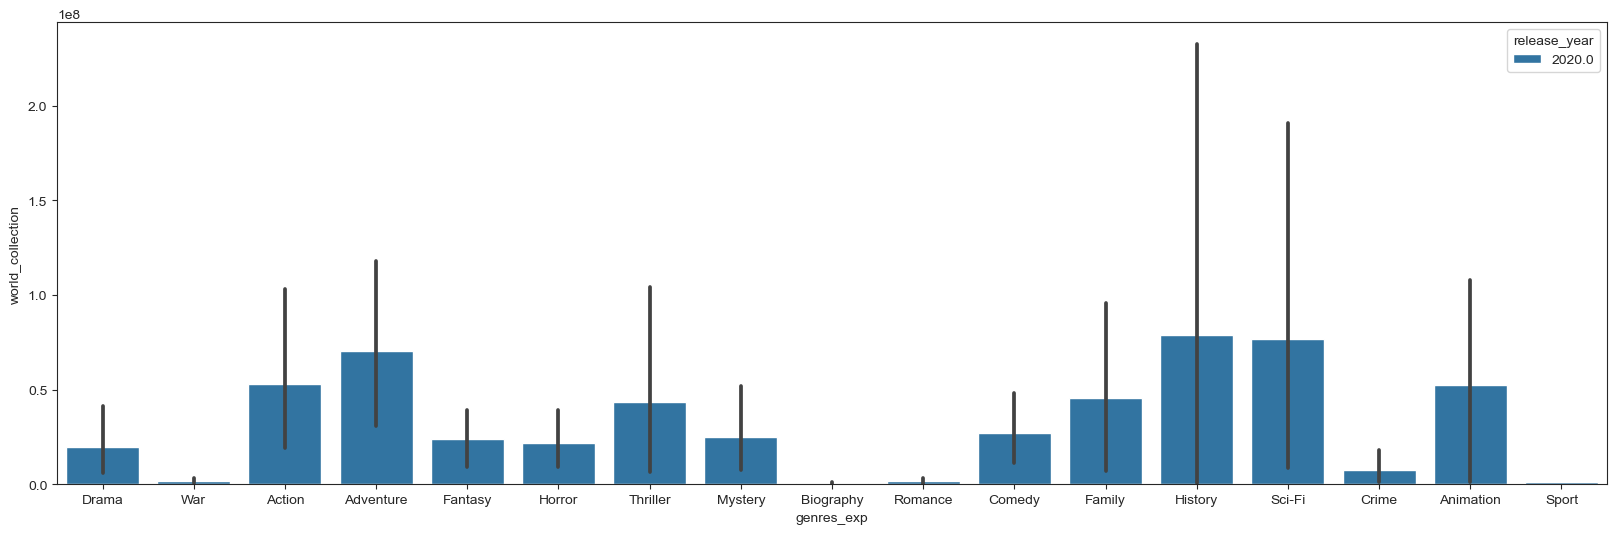

In [46]:
# styling
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
# plotting
sns.barplot(data=non_franchaise_df,
            x='genres_exp',
            y='world_collection',
            hue='release_year')
plt.show()

### side by side

In [47]:
franchaise_df_main.loc[~main_df['belongs_to_collection.name'].isna(),'franchaise'] = True

In [48]:
franchaise_df_main.loc[main_df['belongs_to_collection.name'].isna(),'franchaise'] = False

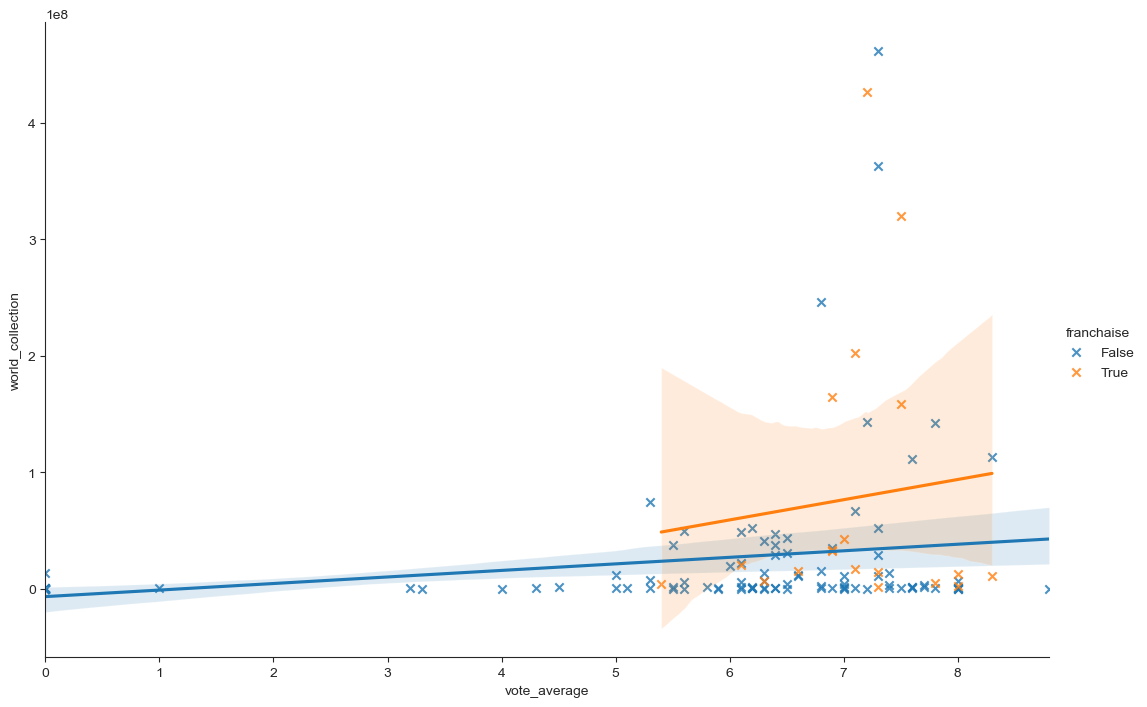

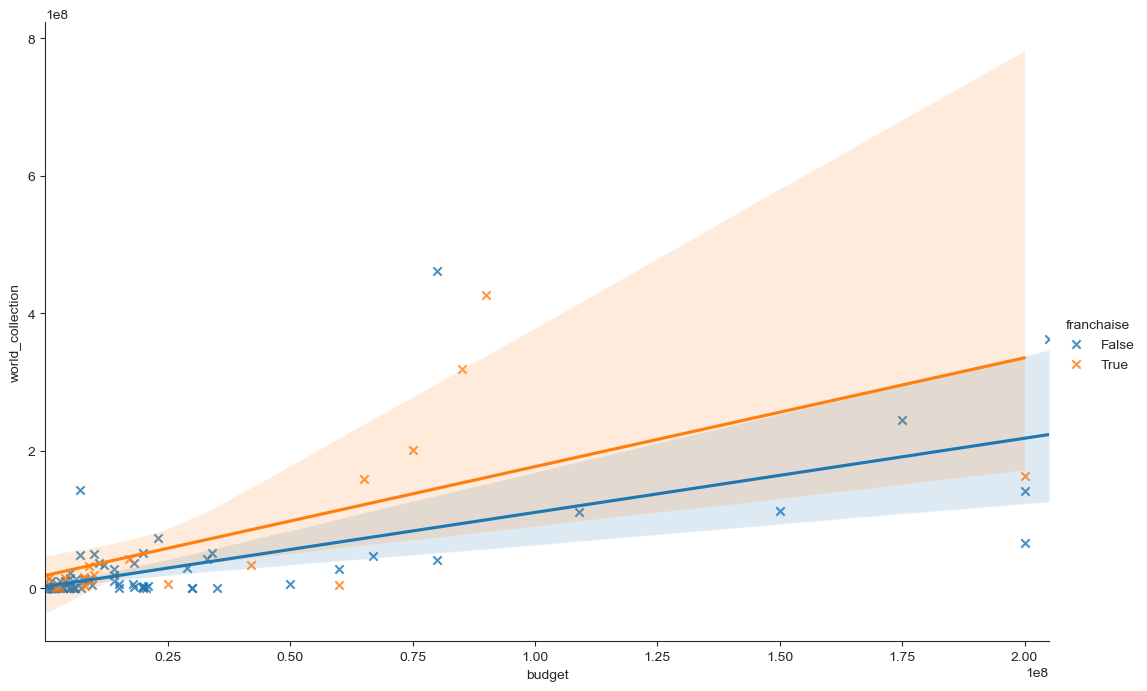

In [49]:
sns.lmplot(data=franchaise_df_main, x='vote_average' , y='world_collection', hue='franchaise', height=7,aspect=1.5, markers='x',)
sns.lmplot(data=franchaise_df_main, x='budget' , y='world_collection', hue='franchaise', height=7,aspect=1.5, markers='x',)
plt.show()

## most successfull genere combo

## profitability

### budget vs profitability

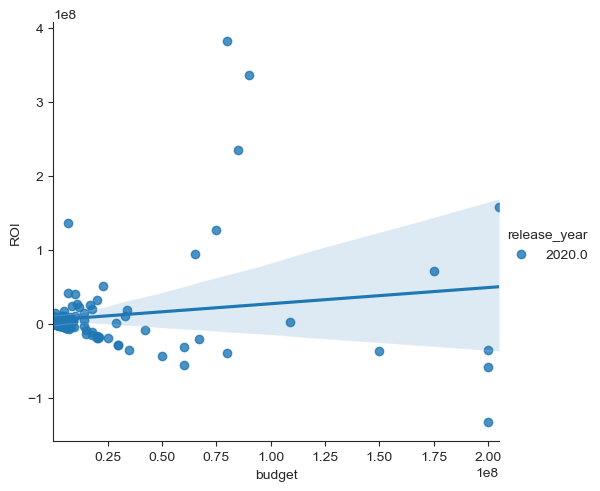

In [50]:
sns.lmplot(data=main_df, x='budget', y='ROI',hue='release_year')
plt.show()

### runtime on profitability

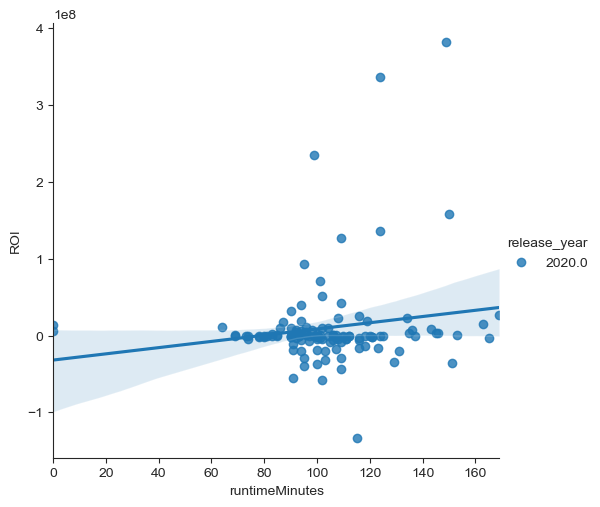

In [51]:
sns.lmplot(data=main_df, x='runtimeMinutes', y='ROI',hue='release_year')
plt.show()

### user rating on profitability

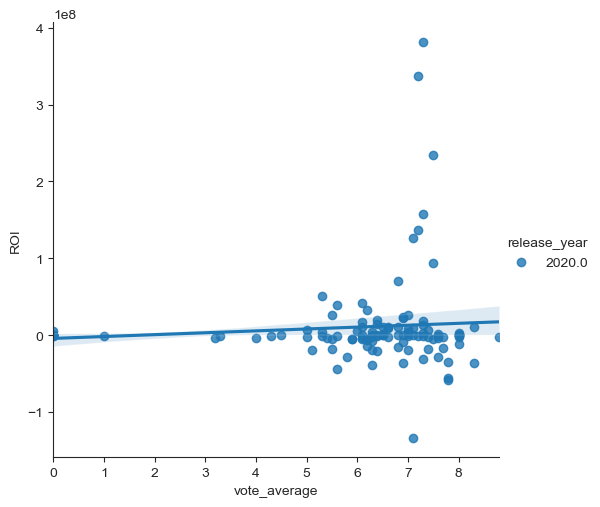

In [52]:
sns.lmplot(data=main_df, x='vote_average', y='ROI',hue='release_year')
plt.show()

## most profitable director

In [62]:
director_df

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,profession,titles_
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050976,tt0050986,tt0060827,tt0069467",director,tt0050976
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050976,tt0050986,tt0060827,tt0069467",director,tt0050986
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050976,tt0050986,tt0060827,tt0069467",director,tt0060827
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050976,tt0050986,tt0060827,tt0069467",director,tt0069467
7,nm0000008,Marlon Brando,1924,2004,"actor,soundtrack,director","tt0047296,tt0068646,tt0070849,tt0078788",director,tt0047296
...,...,...,...,...,...,...,...,...
10775150,nm9993708,Eli Bevins,\N,\N,"director,writer,editor","tt11753904,tt11772858,tt11702702,tt11772904",director,tt11772904
10775151,nm9993709,Lu Bevins,\N,\N,"director,writer,cinematographer","tt11702702,tt11772940,tt11772904,tt11772858",director,tt11702702
10775151,nm9993709,Lu Bevins,\N,\N,"director,writer,cinematographer","tt11702702,tt11772940,tt11772904,tt11772858",director,tt11772940
10775151,nm9993709,Lu Bevins,\N,\N,"director,writer,cinematographer","tt11702702,tt11772940,tt11772904,tt11772858",director,tt11772904


In [63]:
director_df.loc[:,'titles_'] = director_df['knownForTitles'].map(lambda x: x.split(','))
director_df = director_df.explode('titles_')

In [64]:
director_df

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,profession,titles_
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050976,tt0050986,tt0060827,tt0069467",director,tt0050976
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050976,tt0050986,tt0060827,tt0069467",director,tt0050986
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050976,tt0050986,tt0060827,tt0069467",director,tt0060827
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050976,tt0050986,tt0060827,tt0069467",director,tt0069467
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050976,tt0050986,tt0060827,tt0069467",director,tt0050976
...,...,...,...,...,...,...,...,...
10775151,nm9993709,Lu Bevins,\N,\N,"director,writer,cinematographer","tt11702702,tt11772940,tt11772904,tt11772858",director,tt11772858
10775151,nm9993709,Lu Bevins,\N,\N,"director,writer,cinematographer","tt11702702,tt11772940,tt11772904,tt11772858",director,tt11702702
10775151,nm9993709,Lu Bevins,\N,\N,"director,writer,cinematographer","tt11702702,tt11772940,tt11772904,tt11772858",director,tt11772940
10775151,nm9993709,Lu Bevins,\N,\N,"director,writer,cinematographer","tt11702702,tt11772940,tt11772904,tt11772858",director,tt11772904


In [71]:
%%time
sqldf(
    """SELECT DISTINCT b.imdb_id, a.nconst,a.primaryName, b.world_collection FROM director_df AS a JOIN main_df AS b ON a.titles_=b.imdb_id ORDER BY b.world_collection DESC LIMIT 50;"""
)

Wall time: 56.3 s


,imdb_id,nconst,primaryName,world_collection
0,tt7294150,nm12083212,Lolly Sawant,461341525
1,tt7294150,nm1299690,Hu Guan,461341525
2,tt7294150,nm9156865,Siyang Zhang,461341525
3,tt1502397,nm0331628,Janine Gosselin,426505244
4,tt1502397,nm10454383,Alex Bernadotte,426505244
5,tt1502397,nm1103665,Noah Thomson,426505244
6,tt1502397,nm3363895,Christopher Rucinski,426505244
7,tt1502397,nm3648390,Oren Tuvia,426505244
8,tt1502397,nm4011661,Gissette Valentin,426505244
9,tt1502397,nm4087973,MmJoe Sanchez,426505244


## most profitable actors

# WIP

add name to main df

In [60]:
test = director_df.copy()

In [62]:
test.loc[:,'titles_'] = test['knownForTitles'].map(lambda x: x.split(','))
test = test.explode('titles_')

In [88]:
test

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,profession,titles_
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050976,tt0050986,tt0060827,tt0069467",director,tt0050976
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050976,tt0050986,tt0060827,tt0069467",director,tt0050986
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050976,tt0050986,tt0060827,tt0069467",director,tt0060827
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050976,tt0050986,tt0060827,tt0069467",director,tt0069467
7,nm0000008,Marlon Brando,1924,2004,"actor,soundtrack,director","tt0047296,tt0068646,tt0070849,tt0078788",director,tt0047296
...,...,...,...,...,...,...,...,...
10775150,nm9993708,Eli Bevins,\N,\N,"director,writer,editor","tt11753904,tt11772858,tt11702702,tt11772904",director,tt11772904
10775151,nm9993709,Lu Bevins,\N,\N,"director,writer,cinematographer","tt11702702,tt11772940,tt11772904,tt11772858",director,tt11702702
10775151,nm9993709,Lu Bevins,\N,\N,"director,writer,cinematographer","tt11702702,tt11772940,tt11772904,tt11772858",director,tt11772940
10775151,nm9993709,Lu Bevins,\N,\N,"director,writer,cinematographer","tt11702702,tt11772940,tt11772904,tt11772858",director,tt11772904


In [32]:
# test.pivot(index='titles_',columns='nconst')

In [ ]:
test.pivot()

In [83]:
tt = test.melt('titles_')

In [85]:
tt[tt.variable == 'nconst']

,titles_,variable,value
0,tt0050976,nconst,nm0000005
1,tt0050986,nconst,nm0000005
2,tt0060827,nconst,nm0000005
3,tt0069467,nconst,nm0000005
4,tt0047296,nconst,nm0000008
...,...,...,...
1549283,tt11772904,nconst,nm9993708
1549284,tt11702702,nconst,nm9993709
1549285,tt11772940,nconst,nm9993709
1549286,tt11772904,nconst,nm9993709


In [64]:
ii = test.set_index('titles_').stack().reset_index()

In [65]:
ii

,titles_,level_1,0
0,tt0050976,nconst,nm0000005
1,tt0050976,primaryName,Ingmar Bergman
2,tt0050976,birthYear,1918
3,tt0050976,deathYear,2007
4,tt0050976,primaryProfession,"writer,director,actor"
...,...,...,...
10845011,tt11772858,birthYear,\N
10845012,tt11772858,deathYear,\N
10845013,tt11772858,primaryProfession,"director,writer,cinematographer"
10845014,tt11772858,knownForTitles,"tt11702702,tt11772940,tt11772904,tt11772858"


In [74]:
cc = ii[ii['titles_']=='tt0133093']
cc.to_clipboard()

,titles_,level_1,0
101255,tt0133093,nconst,nm0032810
101256,tt0133093,primaryName,Julian Arahanga
101257,tt0133093,birthYear,1972
101258,tt0133093,deathYear,\N
101259,tt0133093,primaryProfession,"director,producer,actor"
...,...,...,...
10240547,tt0133093,birthYear,\N
10240548,tt0133093,deathYear,\N
10240549,tt0133093,primaryProfession,"animation_department,director,producer"
10240550,tt0133093,knownForTitles,"tt6803764,tt0242653,tt0234215,tt0133093"


In [80]:
cc[cc[0]=='director']

,titles_,level_1,0
101261,tt0133093,profession,director
111362,tt0133093,profession,director
267014,tt0133093,profession,director
358840,tt0133093,profession,director
504979,tt0133093,profession,director
521366,tt0133093,profession,director
588370,tt0133093,profession,director
601152,tt0133093,profession,director
639911,tt0133093,profession,director
693398,tt0133093,profession,director


In [44]:
test.stack().reset_index()

,level_0,level_1,0
0,4,nconst,nm0000005
1,4,primaryName,Ingmar Bergman
2,4,birthYear,1918
3,4,deathYear,2007
4,4,primaryProfession,"writer,director,actor"
...,...,...,...
31563,3466,deathYear,\N
31564,3466,primaryProfession,"writer,producer,director"
31565,3466,knownForTitles,"tt10549038,tt12205026,tt12273618,tt7752842"
31566,3466,profession,director


In [236]:
tt = main_df.copy()

In [244]:
tt

,imdb_id,primaryTitle,originalTitle,startYear,release_date,runtimeMinutes,budget,world_collection,int_collection,dom_collection,popularity,vote_average,vote_count,overview,belongs_to_collection.name,genres,production_comp,ROI,ROI_percentage,release_year
825,tt0783640,The Last Full Measure,The Last Full Measure,2019,2020-01-23,116,20000000,3364426,415214.0,2949212.0,19.160,7.7,247,The incredible true story of Vietnam War hero ...,NaN,"Drama,War","Foresight Unlimited, Provocator, SSS Entertain...",-16635574,-0.831779,1
2009,tt0983946,Fantasy Island,Fantasy Island,2020,2020-02-12,109,7000000,48811343,21502054.0,27309289.0,28.579,6.1,1450,A group of contest winners arrive at an island...,NaN,"Action,Adventure,Fantasy","Blumhouse Productions, Columbia Pictures",41811343,5.973049,2
2230,tt10044182,Block Z,Block Z,2020,2020-01-29,101,646955,709452,NaN,NaN,4.605,8.0,6,A pre-med student and her friends encounter th...,NaN,"Action,Horror,Thriller","Star Cinema – ABS-CBN Film Productions, Keep F...",62497,0.096602,1
2237,tt10059518,Unhinged,Unhinged,2020,2020-07-16,90,33000000,43249465,22418000.0,20831465.0,25.447,6.5,666,A divorced mother honks impatiently at a deran...,NaN,"Action,Thriller","Solstice Productions, Burek Films, Ingenious M...",10249465,0.310590,7
2239,tt10065694,Antebellum,Antebellum,2020,2020-09-02,105,15000000,6852361,6852361.0,NaN,108.786,6.3,433,Successful author Veronica finds herself trapp...,NaN,"Drama,Horror,Mystery","Lionsgate, QC Entertainment, Metropolitan Film...",-8147639,-0.543176,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25670,tt9624766,Jiu Jitsu,Jiu Jitsu,2020,2020-11-20,102,23000000,74000000,99924.0,NaN,772.958,5.3,313,"Every six years, an ancient order of jiu-jitsu...",NaN,"Action,Comedy,Fantasy","Acme Rocket Fuel, Green Olive Films, Double Tr...",51000000,2.217391,11
25697,tt9648672,Street Dancer 3D,Street Dancer 3D,2020,2020-01-24,146,9204790,12589965,10339127.0,NaN,5.118,8.0,15,Two rival dance groups from India and Pakistan...,ABCD Collection,"Drama,Music","T-Series, UTV Motion Pictures, Dance Film Comp...",3385175,0.367762,1
25772,tt9742392,Kindred,Kindred,2020,2020-11-06,101,3000000,8921,NaN,8921.0,10.457,6.3,5,When her boyfriend Ben suddenly dies in an acc...,NaN,"Drama,Horror,Mystery","Reiver Pictures, IFC Midnight, Head Gear Films...",-2991079,-0.997026,11
25792,tt9770150,Nomadland,Nomadland,2020,2020-12-26,107,5000000,1414069,178069.0,1236000.0,51.220,7.6,276,A woman in her sixties embarks on a journey th...,NaN,Drama,"Cor Cordium Productions, Hear/Say Productions,...",-3585931,-0.717186,12


In [238]:
tt['release_year'] = tt['release_date'].dt.month

In [252]:
tt['release_timing'] = pd.cut(tt['release_year'],bins=[0,6,8,10,12],labels=['dump months', 'summer','dump months','holidays'],ordered=False)

In [253]:
tt

,imdb_id,primaryTitle,originalTitle,startYear,release_date,runtimeMinutes,budget,world_collection,int_collection,dom_collection,...,vote_average,vote_count,overview,belongs_to_collection.name,genres,production_comp,ROI,ROI_percentage,release_year,release_timing
825,tt0783640,The Last Full Measure,The Last Full Measure,2019,2020-01-23,116,20000000,3364426,415214.0,2949212.0,...,7.7,247,The incredible true story of Vietnam War hero ...,NaN,"Drama,War","Foresight Unlimited, Provocator, SSS Entertain...",-16635574,-0.831779,1,dump months
2009,tt0983946,Fantasy Island,Fantasy Island,2020,2020-02-12,109,7000000,48811343,21502054.0,27309289.0,...,6.1,1450,A group of contest winners arrive at an island...,NaN,"Action,Adventure,Fantasy","Blumhouse Productions, Columbia Pictures",41811343,5.973049,2,dump months
2230,tt10044182,Block Z,Block Z,2020,2020-01-29,101,646955,709452,NaN,NaN,...,8.0,6,A pre-med student and her friends encounter th...,NaN,"Action,Horror,Thriller","Star Cinema – ABS-CBN Film Productions, Keep F...",62497,0.096602,1,dump months
2237,tt10059518,Unhinged,Unhinged,2020,2020-07-16,90,33000000,43249465,22418000.0,20831465.0,...,6.5,666,A divorced mother honks impatiently at a deran...,NaN,"Action,Thriller","Solstice Productions, Burek Films, Ingenious M...",10249465,0.310590,7,summer
2239,tt10065694,Antebellum,Antebellum,2020,2020-09-02,105,15000000,6852361,6852361.0,NaN,...,6.3,433,Successful author Veronica finds herself trapp...,NaN,"Drama,Horror,Mystery","Lionsgate, QC Entertainment, Metropolitan Film...",-8147639,-0.543176,9,dump months
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25670,tt9624766,Jiu Jitsu,Jiu Jitsu,2020,2020-11-20,102,23000000,74000000,99924.0,NaN,...,5.3,313,"Every six years, an ancient order of jiu-jitsu...",NaN,"Action,Comedy,Fantasy","Acme Rocket Fuel, Green Olive Films, Double Tr...",51000000,2.217391,11,holidays
25697,tt9648672,Street Dancer 3D,Street Dancer 3D,2020,2020-01-24,146,9204790,12589965,10339127.0,NaN,...,8.0,15,Two rival dance groups from India and Pakistan...,ABCD Collection,"Drama,Music","T-Series, UTV Motion Pictures, Dance Film Comp...",3385175,0.367762,1,dump months
25772,tt9742392,Kindred,Kindred,2020,2020-11-06,101,3000000,8921,NaN,8921.0,...,6.3,5,When her boyfriend Ben suddenly dies in an acc...,NaN,"Drama,Horror,Mystery","Reiver Pictures, IFC Midnight, Head Gear Films...",-2991079,-0.997026,11,holidays
25792,tt9770150,Nomadland,Nomadland,2020,2020-12-26,107,5000000,1414069,178069.0,1236000.0,...,7.6,276,A woman in her sixties embarks on a journey th...,NaN,Drama,"Cor Cordium Productions, Hear/Say Productions,...",-3585931,-0.717186,12,holidays
